In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import copy
import scipy.optimize as optimize
import time

from newtest import child_model
import NPL
from Solve_test import solve_NFXP
import estimate_test as estimate


In [2]:
model = child_model()

Simulate data with solved model

In [10]:
# Simulate the data
# Set up

solver = solve_NFXP()

# update starting value: 
ev0 = np.zeros((model.n))
ev,pk = solver.poly(model.bellman, ev0, beta = model.beta, output=2)

# data
data = model.sim_data(pk) 
samplesize = data.shape[0]

In [11]:
tabulate = data.dx1.value_counts()
tabulate
#[tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]


0    13452
1     6548
Name: dx1, dtype: int64

In [12]:
print('Model grid:\n',model.grid)
print('Transition probabilities conditional on no contraception:\n',model.P1)
print('Transition probabilities conditional on contraception:\n',model.P2)
print('Bellman one run:\n',ev)
print('Bellman pk:\n',pk)

Model grid:
 [0 1 2 3 4]
Transition probabilities conditional on no contraception:
 [[0.30326697 0.69673303 0.         0.         0.        ]
 [0.         0.30326697 0.69673303 0.         0.        ]
 [0.         0.         0.30326697 0.69673303 0.        ]
 [0.         0.         0.         0.30326697 0.69673303]
 [0.         0.         0.         0.         1.        ]]
Transition probabilities conditional on contraception:
 [[0.97149143 0.02850857 0.         0.         0.        ]
 [0.         0.97149143 0.02850857 0.         0.        ]
 [0.         0.         0.97149143 0.02850857 0.        ]
 [0.         0.         0.         0.97149143 0.02850857]
 [0.         0.         0.         0.         1.        ]]
Bellman one run:
 [48.07537759 47.40416571 46.90721666 46.57992108 46.41813136]
Bellman pk:
 [0.38917245 0.41690059 0.44441151 0.47158369 0.49831073]


Estimate parameters with log likelihood loop

In [14]:
# Find tha likelihood value for different combinations 
ev = np.zeros((model.n))
par_mu = copy.copy(model.mu)
par_eta2 = copy.copy(model.eta2)


NRC = 200
Nc = 200

log_lik = np.nan + np.zeros((NRC,Nc))
mu = np.linspace(-1,-1,NRC)
eta2 = np.linspace(-1,1,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p
        data0 = data[data['d'] == 0]
        data1 = data[data['d'] == 1]
    
        tabulate0 = data0.dx1.value_counts()
        tabulate1 = data1.dx1.value_counts()

        p1 = [tabulate0[i]/sum(tabulate0) for i in range(tabulate0.size)]
        p2 = [tabulate1[i]/sum(tabulate1) for i in range(tabulate1.size)] 
    
        
        
        # STEP 2: Estimate structual parameters
        model.p1 = p1 # Use first step estimates as starting values for t
        model.p2 = p2
        
        # Estimate RC and C
        pnames = ['mu','eta2']
        theta = np.array([mu[i], eta2[j]])
        log_lik[i,j]=estimate.ll(theta,model, solver,data, pnames, no_guess=True)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.mu = copy.copy(par_mu)
model.eta2 = copy.copy(par_eta2)

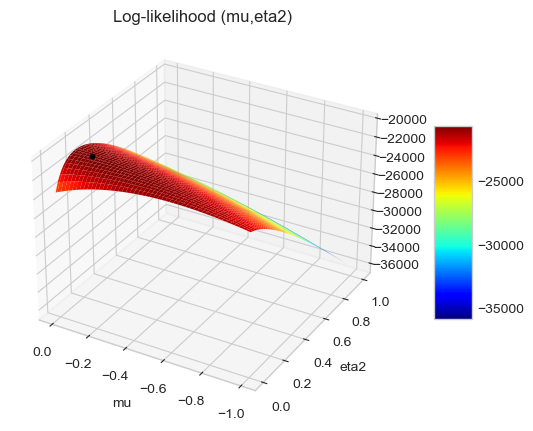

-0.10101010101010088 0.15151515151515152


In [7]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d', computed_zorder=False)

# Make data.
X, Y = np.meshgrid(mu, eta2,indexing='ij')
x, y = np.unravel_index(np.argmax(log_lik), log_lik.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

#Plot max value
max = ax.scatter(mu[x], eta2[y], log_lik[x,y], color=['black'], marker='o', s=10)

# Customize the axis.
ax.set_xlabel(f'mu')
ax.set_ylabel(f'eta2')
ax.set_title(f'Log-likelihood (mu,eta2)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
print(mu[x], eta2[y])


Use estimate function to estimate parameters

In [13]:
theta0 = [0.000001, 0.000001, 0.0000001]
# Print the result
print(f'Structual estimation')
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')
print(f'Sample size = {samplesize}\n \n')

print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}              {theta_hat[0]:.4f}     {np.sqrt(Avar[0,0]):.4f} ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}     {np.sqrt(Avar[1,1]):.4f} ')
print(f'{pnames[2]}              {theta_hat[2]:.4f}     {np.sqrt(Avar[2,2]):.4f}  \n ')


print(f'Log-likelihood {-nfxp_results.fun*samplesize:.2f}') 
print(f'The model converged: {converged}')

print(nfxp_results)

Structual estimation
Beta        = 0.9900
n           = 5
Sample size = 20000
 

Parameters     Estimates    s.e. 
mu              0.0068     0.0226 
eta2              -0.0581     0.0182 
eta3              -0.0000     51688.5770  
 
Log-likelihood -20699.66
The model converged: True
     fun: 1.034983156512142
    hess: array([[ 2.93762785e-01, -9.47251698e-01,  3.76665005e-07],
       [-9.47251698e-01,  5.14857455e+00, -1.92525688e-06],
       [ 3.76665005e-07, -1.92525688e-06,  7.42862875e-13]])
     jac: array([-5.62333280e-06, -3.69982244e-05, -1.00345283e-08])
 message: 'A bad approximation caused failure to predict improvement.'
    nfev: 20
    nhev: 6
     nit: 24
    njev: 6
  status: 2
 success: False
       x: array([ 6.75710823e-03, -5.80873677e-02, -4.11079656e-08])


Estimate parameters on real data

In [32]:
model=child_model()
solver = solve_NFXP()

In [33]:
dta = model.read_data()
samplesize = dta.shape[0]
uncond_R_P = sum(dta.d)/samplesize

# Estimate
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,dta)

In [34]:
# Print the result
print(f'Structual estimation')
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')
print(f'Sample size = {samplesize}\n \n')

print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}              {theta_hat[0]:.4f}     {np.sqrt(Avar[0,0]):.4f} ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}     {np.sqrt(Avar[1,1]):.4f} ')
print(f'{pnames[2]}              {theta_hat[2]:.4f}     {np.sqrt(Avar[2,2]):.4f}  \n ')


print(f'Log-likelihood {-optim_res.fun*samplesize:.2f}') 
print(f'The model converged: {converged}')
optim_res
print(optim_res)

Structual estimation
Beta        = 0.9900
n           = 5
Sample size = 20679
 

Parameters     Estimates    s.e. 
mu              0.0000     0.0152 
eta2              0.1000     0.0139 
eta3              0.0000     157.7283  
 
Log-likelihood -21748.51
The model converged: True
     fun: 1.0517197801966598
    hess: array([[2.16136776e+02, 1.63068895e+03, 1.27179784e-01],
       [1.63068895e+03, 1.23296018e+04, 9.61855259e-01],
       [1.27179784e-01, 9.61855259e-01, 7.50404542e-05]])
     jac: array([-1.27877077e+01, -9.55206913e+01, -7.44118091e-03])
 message: 'A bad approximation caused failure to predict improvement.'
    nfev: 29
    nhev: 2
     nit: 30
    njev: 2
  status: 2
 success: False
       x: array([1.e-05, 1.e-01, 1.e-05])


Code for data processing

In [ ]:
with open('carro-mira.csv', 'r') as file:
    lines = file.readlines()

# Remove the first character from each line
modified_lines = [line[1:] for line in lines]

# Open the output file in write mode
with open('carro-mira.csv', 'w') as file:
    file.writelines(modified_lines)